<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LIghtGBM" data-toc-modified-id="LIghtGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LIghtGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Лучшая-модель" data-toc-modified-id="Лучшая-модель-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Лучшая модель</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#Импортируем бибилиотеки
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestclassifier
from sklearn.model_selection import (
    cross_val_score,
    RandomizedSearchCV,
    TimeSeriesSplit,
    train_test_split
)

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# настройки
warnings.filterwarnings("ignore")
pd.set_option('display.max_column', None)

# константы заглавными буквами
RANDOM_STATE = 42

In [2]:
# Откроем и прочитаем файл
pth1 = 'datasets/taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, parse_dates = ['datetime'], index_col=['datetime'])
elif os.path.exists(pth1):
    data = pd.read_csv(pth2, parse_dates = ['datetime'], index_col=['datetime'])
else:
    print('wrong somethings')

In [3]:
# Выведем на экран таблицу
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Посмотрим на наличие дубликатов
data.index.duplicated().sum()

0

In [5]:
#Делаем ресамплинг
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:** Данные готовы к работе и не нуждаются в предобработке.


## Анализ

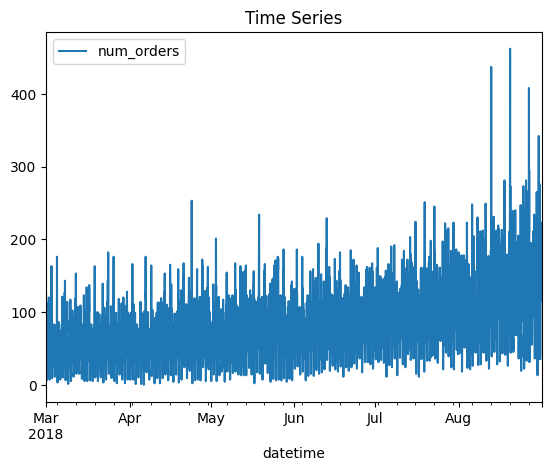

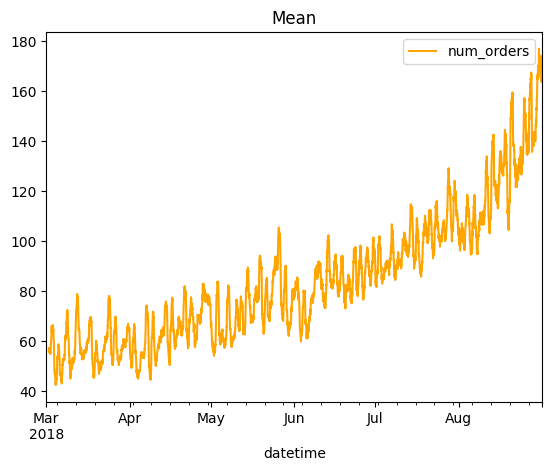

In [6]:
data.plot()
plt.title('Time Series')
data.rolling(24).mean().plot(color='orange')
plt.title('Mean');

**Данный временой ряд нестационарный, т.к. мы наблюдаем увеличение среднего значения. Создадим датасет и посмотрим график  1 недели**

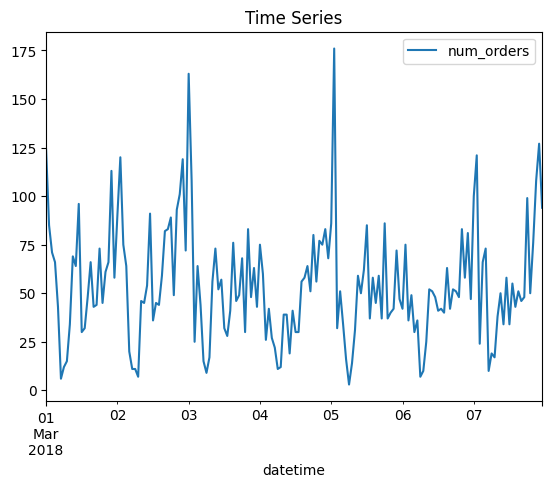

In [7]:
#Посмотрим график 1 недели
df_week = data['2018-03-01': '2018-03-07']

df_week.plot()
plt.title('Time Series');

**У нестационарных рядов можно найти сезоннсть и тренд.**

In [8]:
#Создадим функцию для построения графиков сезонности
def seasonal_and_trend_plot(data):
    decomposed = seasonal_decompose(data)
    plt.title('Seasonal')
    decomposed.seasonal.plot(ax=plt.gca())
    plt.show()
    plt.title('Trend')
    decomposed.trend.plot(ax=plt.gca())
    plt.show()
    plt.title('Resid')
    decomposed.resid.plot(ax=plt.gca())

In [9]:
#Разложим временной ряд на три составляющие: тренд, сезонность и остаток
decomposed = seasonal_decompose(data)
decomposed_week = seasonal_decompose(df_week)

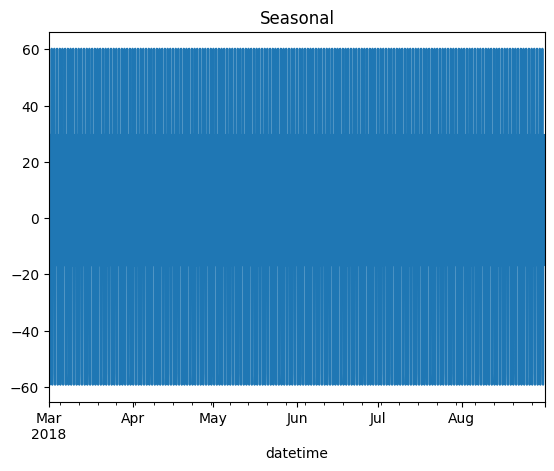

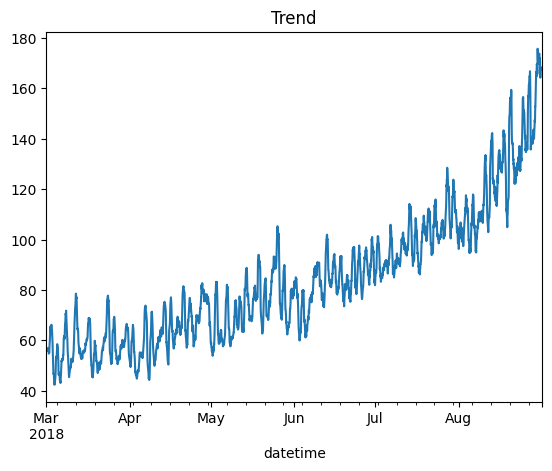

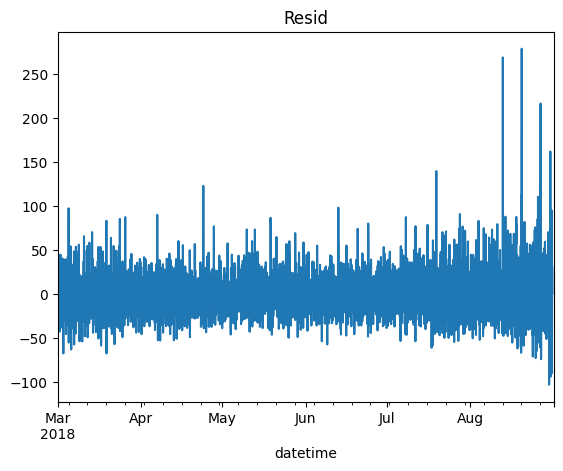

In [10]:
#Применим функцию
seasonal_and_trend_plot(data)

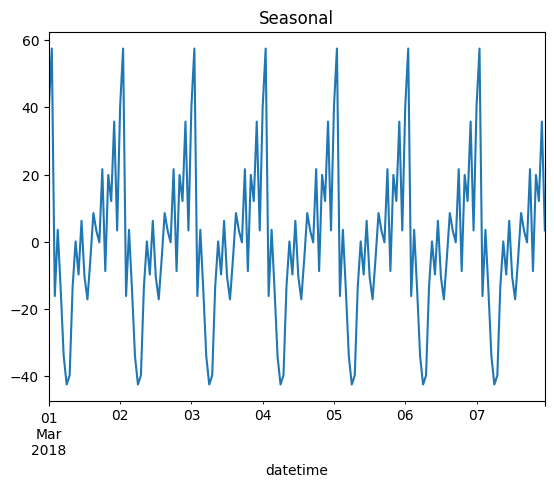

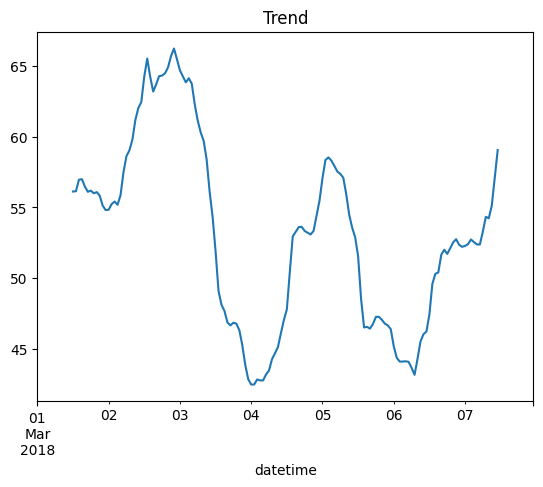

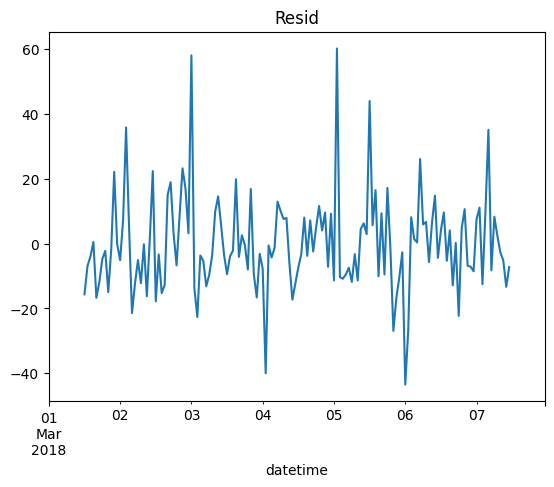

In [11]:
#Применим функцию
seasonal_and_trend_plot(df_week)

**Выводы:** Мы имеем нестационарный ряд, с увеличивающимся средним значением. Анализ показал следующие тенеденции:
- С каждым месяцем количество заказов увеличивается. Что может говорить о возрастании популярности данного сервиса у клиентов.
- Наблюдается сезонность, а именно увеличение числа заказов в ночное время, и упадок в утреннее. 

## Создание признаков

**Т.к. данных для обучения модели слишком мало, создадим такие признаки, как разность временного ряда и скользящее среднее**

In [12]:
#Функция создает признаки разности временного ряда 
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [13]:
df = make_features(data, 24, 48)
df

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,170.895833
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,170.208333
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,169.437500


## Обучение

**В данном пункте будем искать лучшую модель с лучшим показателем RMSE. Для этого используем следующие модели:**
- LinearRegression
- RandomForestRegressor
- LIghtGBMRegrssor
- CatBoostRegressor

In [14]:
# Разбивка на обучающую и тестовую выборку
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features = train.drop('num_orders', axis=1)
target = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

# Пролверим правильность разбивки
train.shape[0]/test.shape[0]

tscv = TimeSeriesSplit(n_splits=5)

### LinearRegression

In [15]:
# Масштабируем
scaler = StandardScaler()
scaler.fit(features) 
features_lr = scaler.transform(features) 

In [16]:
lr = LinearRegression(n_jobs=-1)# обучающая модель
scores= cross_val_score(lr, features_lr, target, cv=tscv, scoring='neg_root_mean_squared_error') 
print(f'Rmse:{- np.mean(scores)}')

Rmse:27.11492715821232


Rmse:24.88004383999813


### RandomForestRegressor

In [17]:
model_rf = RandomForestRegressor()

In [18]:
param_grid_rf = {
    'n_estimators': range(50, 251, 50),
    'max_depth':range(2, 11),
    'min_samples_split': (2, 3, 4),
}

In [19]:
# gs_rf = RandomizedSearchCV(
#     model_rf,
#     param_grid_rf,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     cv=tscv,
#     verbose=30,
#     random_state=RANDOM_STATE
# )

# gs_rf.fit(features, target)

# print(f'best_score: {- gs_rf.best_score_}')
# print(f'best_params: {gs_rf.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
- best_score: 25.926561010524665
- best_params: {'n_estimators': 200, 'min_samples_split': 3, 'max_depth': 10}

### LIghtGBM

In [20]:
cat_features = ['month', 'day', 'dayofweek']
# словарь с гиперпараметрами и значениями, которые хотим перебрать
params_grid_lgb = {
    'n_estimators': range(50, 251, 50),
    'num_leaves': (50, 70, 90),
    'max_depth': range(2, 11),
    'learning_rate': (0.01, 0.05, 0.1, 0.15, 0.2)
}

In [21]:
# lgb_reg = LGBMRegressor(random_state=RANDOM_STATE)

# gs_lgb = RandomizedSearchCV(
#     lgb_reg,
#      params_grid_lgb,
#      scoring='neg_root_mean_squared_error',
#      n_jobs=-1,
#      cv=tscv,
#      verbose=30,
#  )

# gs_lgb.fit(features, target)

# # лучшее значение RMSE и гиперпараметров на кросс-валидации

# print(f'best_score: {- gs_lgb.best_score_}')
# print(f'best_params: {gs_lgb.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
- best_score: 25.697642036873287
- best_params: {'num_leaves': 50, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05}

### CatBoost

In [22]:
# params = {
#     'iterations': [100, 150, 200, 500, 900],
#     'learning_rate': [0.05, 0.1, 0.5, 1],
#     'depth': [6, 8, 10, 12],
# }



# # initialize the model
# cat = CatBoostRegressor(random_seed=42, silent=True)

# # perform grid search with 5-fold cross-validation
# grid_search =RandomizedSearchCV(cat, 
#                                  params, 
#                                  cv=tscv, 
#                                  scoring='neg_root_mean_squared_error',
#                                  n_jobs=-1,)

# # fit the grid search to the data
# grid_search.fit(features, target)

# # print the best hyperparameters
# print(f'best_params: {grid_search.best_params_}')
# print(f'best_score: {-grid_search.best_score_}')

- best_params: {'learning_rate': 0.1, 'iterations': 500, 'depth': 8}
- best_score: 25.034447928430072

### Лучшая модель

In [23]:
result = pd.DataFrame(
    [27.11, 25.92, 25.69, 25.03],
    index=['LinearRegression', 'RandomForestRegressor', \
           'LIghtGBMRegrssor', 'CatBoostRegressor'],
    columns=['RMSE']
)
result

,RMSE
LinearRegression,27.11
RandomForestRegressor,25.92
LIghtGBMRegrssor,25.69
CatBoostRegressor,25.03


**Вывод:** Как видим лучшей моделью является  CatBoostRegressor с RMSE = 25.03. Её и будем использовать.

## Тестирование

In [24]:
cat = CatBoostRegressor(random_seed=42, 
                        silent=True,
                        learning_rate=0.1, 
                        iterations=500, 
                        depth=8)

cat.fit(features, target)
predictions = cat.predict(features_test)
print(f'rmse: {np.sqrt(mean_squared_error(target_test, predictions))}')

rmse: 41.61284519739952


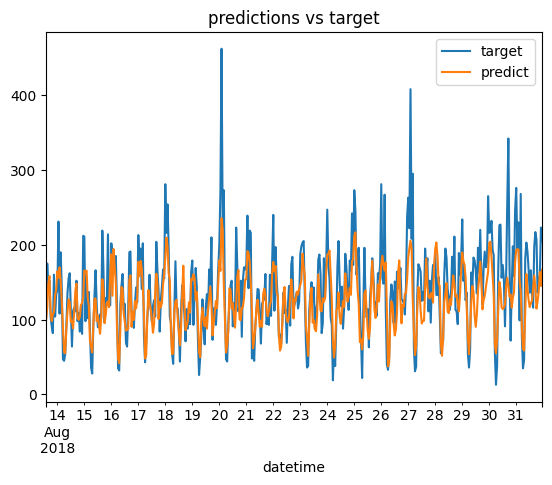

In [25]:
#Построим график для сравнения предсказанных и реальных значений
predict_vs_target = pd.DataFrame({'target':target_test.values, 'predict':predictions}, index=target_test.index)
predict_vs_target.plot()
plt.title('predictions vs target');

Предсказанная модель в основном повторяет график реальных значений. И похож на усредненный график . Что показывает нам что модель часто ошибается при предсказывании больших значений или же очень маленьких. Вслучае невозможности улучшения точности, следует создать для таких предсказанных данных доверительный интервал.

**Вывод:** Метрика RMSE=41.61, что меньше 48. Таким образом условие заказчика было выполнено. Рекомендуется использовать данную модель для предсказания количества заказов.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48